# Analysis of Variance (ANOVA)
- The ANOVA test is used to compare the means of more than 2 groups.
    - Note that the t-test can be used to compare 2 groups.
- ANOVA uses variance-based F test to check the group mean equality.
 - $H_0$: groups means are equal (no variation in means of groups).
 - $H_1$: at least one group mean is different from other groups.
- ANOVA Assumptions:
    - Residuals (experimental error) are normally distribution.
        - You may use the Shapiro-Wilks test.
    - Homogeneity of variances: variances are equal between treatment groups.
        - If not, use Bartlett's or Levene's Test.
    - Observations are sampled independently from each other.
- References:
    - https://www.reneshbedre.com/blog/anova.html

## One-Way ANOVA

<center>
<img src = "https://www.reneshbedre.com/assets/posts/anova/one_way_model.webp" width = "600px"/>
</center>

In [1]:
!wget https://reneshbedre.github.io/assets/posts/anova/onewayanova.txt

--2021-06-08 09:53:24--  https://reneshbedre.github.io/assets/posts/anova/onewayanova.txt
Resolving reneshbedre.github.io (reneshbedre.github.io)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to reneshbedre.github.io (reneshbedre.github.io)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 503 Service Unavailable
2021-06-08 09:53:24 ERROR 503: Service Unavailable.



A   B   C   D
0  25  45  30  54
1  30  55  29  60
2  28  29  33  51
3  36  56  37  62
4  29  40  27  73

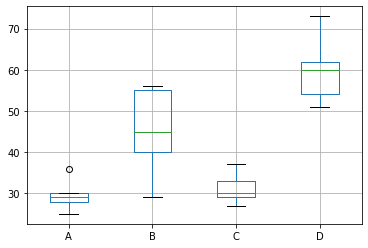

In [2]:
import pandas as pd

tbl = pd.read_csv("onewayanova.txt", sep = "\t")
tbl.boxplot(column = ['A', 'B', 'C', 'D'])
tbl

### F Test

In [3]:
import scipy.stats as stats

fvalue, pvalue = stats.f_oneway(tbl['A'], tbl['B'], tbl['C'], tbl['D'])
print(fvalue, pvalue)

17.492810457516338 2.639241146210922e-05


### Test by Linear Regression Model

In [4]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

tbl2 = pd.melt(tbl.reset_index(), id_vars = ['index'], value_vars = ['A', 'B', 'C', 'D'])
tbl2.columns = ['index', 'treatments', 'value']

tbl2

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


index treatments  value
0       0          A     25
1       1          A     30
2       2          A     28
3       3          A     36
4       4          A     29
5       0          B     45
6       1          B     55
7       2          B     29
8       3          B     56
9       4          B     40
10      0          C     30
11      1          C     29
12      2          C     33
13      3          C     37
14      4          C     27
15      0          D     54
16      1          D     60
17      2          D     51
18      3          D     62
19      4          D     73

In [5]:
model = ols('value ~ C(treatments)', data = tbl2).fit()
anova_table = sm.stats.anova_lm(model)
anova_table

df   sum_sq   mean_sq         F    PR(>F)
C(treatments)   3.0  3010.95  1003.650  17.49281  0.000026
Residual       16.0   918.00    57.375       NaN       NaN

### Multiple Comparison: Tukey-Kramer Test
- Tukey's HSD test accounts for multiple comparisons and corrects for family-wise error rate (FWER) (inflated type I error).

<center>
<img src = "https://www.reneshbedre.com/assets/posts/anova/tukey.webp" width = "600px"/>
</center>

- References:
    - https://en.wikipedia.org/wiki/Tukey%27s_range_test

In [6]:
%%capture

!pip install pingouin 

In [7]:
from pingouin import pairwise_tukey

tbl3 = pairwise_tukey(data = tbl2, dv = 'value', between = 'treatments')
print(tbl3)

   A  B  mean(A)  mean(B)  diff        se         T   p-tukey    hedges
0  A  B     29.6     45.0 -15.4  4.790616 -3.214618  0.025070 -1.836351
1  A  C     29.6     31.2  -1.6  4.790616 -0.333986  0.900000 -0.190790
2  A  D     29.6     60.0 -30.4  4.790616 -6.345739  0.001000 -3.625005
3  B  C     45.0     31.2  13.8  4.790616  2.880632  0.048178  1.645561
4  B  D     45.0     60.0 -15.0  4.790616 -3.131121  0.029578 -1.788654
5  C  D     31.2     60.0 -28.8  4.790616 -6.011753  0.001000 -3.434215


### Assumption Test

#### Normality Test: Shapiro-Wilk Test
- References:
    - https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test

In [8]:
import scipy.stats as stats

w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.9685019850730896 0.7229772806167603


#### Homogeneity of Variances: Bartlett's Test 
- As the data is drawn from normal distribution, use Bartlett’s test to check the homogeneity of variances.
- References:
    - https://en.wikipedia.org/wiki/Bartlett%27s_test

In [9]:
import scipy.stats as stats

w, pvalue = stats.bartlett(tbl['A'], tbl['B'], tbl['C'], tbl['D'])
print(w, pvalue)

5.687843565012841 0.1278253399753447


#### Homogeneity of Variances: Levene's Test
- Levene’s test can be used to check the homogeneity of variances when the data is not drawn from normal distribution.

In [10]:
%%capture

!pip install bioinfokit

In [11]:
from bioinfokit.analys import stat 

res = stat()
res.levene(df = tbl2, res_var = "value", xfac_var = "treatments")
res.levene_summary

Parameter   Value
0      Test statistics (W)  1.9220
1  Degrees of freedom (Df)  3.0000
2                  p value  0.1667

## Two-Way ANOVA

<center>
<img src = "https://www.reneshbedre.com/assets/posts/anova/model_twoway.webp" width = "600px"/>
</center>

### Example 1
- A study of the effect of temperature on percent shrinkage in dyeing fabrics was made on two
replications for each of three types of fabric in a completely randomized design.
- The data are the percent shrinkage of two replicate fabric pieces dried at each of the four temperature.

In [12]:
!wget https://www.csie.ntu.edu.tw/~d00922011/stats/data/Problem1_data.csv

--2021-06-08 09:53:31--  https://www.csie.ntu.edu.tw/~d00922011/stats/data/Problem1_data.csv
Resolving www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)... 140.112.30.26
Connecting to www.csie.ntu.edu.tw (www.csie.ntu.edu.tw)|140.112.30.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 433 [text/csv]
Saving to: ‘Problem1_data.csv.2’

Problem1_data.csv.2 100%[===================>]     433  --.-KB/s    in 0s      

2021-06-08 09:53:33 (33.0 MB/s) - ‘Problem1_data.csv.2’ saved [433/433]



In [13]:
df = pd.read_csv("Problem1_data.csv")
df[-5:]

Fabric Temperature  Response
19  Type3       215 F       3.5
20  Type3       220 F       5.7
21  Type3       220 F       5.8
22  Type3       225 F      10.9
23  Type3       225 F      11.1

#### Interaction Test
- $H_0$: $(\alpha\beta)_{jk} = 0$ for all $j = 1, 2$ and $k = 1, 2, 3, 4.$
- $H_1$: at least one $(\alpha\beta)_{jk} \neq 0.$

In [14]:
model1 = ols("Response ~  C(Fabric) + C(Temperature) + C(Fabric) : C(Temperature)", data = df).fit()
sm.stats.anova_lm(model1)

df      sum_sq  ...            F        PR(>F)
C(Fabric)                  2.0   13.055833  ...   136.234783  5.634724e-09
C(Temperature)             3.0  172.361250  ...  1199.034783  3.956639e-15
C(Fabric):C(Temperature)   6.0    5.467500  ...    19.017391  1.754015e-05
Residual                  12.0    0.575000  ...          NaN           NaN

[4 rows x 5 columns]

#### Main Effect Test
- Fabric
 - $H_0$: $\alpha_j = 0$ for all $j = 1, 2$.
- Temperature
 - $H_0$: $\beta_k = 0$ for all $k = 1, 2, 3, 4$.

In [15]:
model2 = ols("Response ~ C(Fabric) + C(Temperature)", data = df).fit()
sm.stats.anova_lm(model2)

df      sum_sq    mean_sq           F        PR(>F)
C(Fabric)        2.0   13.055833   6.527917   19.446007  3.176806e-05
C(Temperature)   3.0  172.361250  57.453750  171.148945  2.035260e-13
Residual        18.0    6.042500   0.335694         NaN           NaN

#### Remarks:
- In this case, the model 2 is redundant because doing the model 1  is enough.
- You need the model 2 only when the model 1 cannot reject $H_0$.

### Example 2
- Story (aka experiment):
    - A botanist wants to know whether or not plant growth is influenced by sunlight exposure and watering frequency.
    - She plants 30 seeds and lets them grow for two months under different conditions for sunlight exposure and watering frequency.
    - After two months, she records the height of each plant, in inches.
- Analysis:
    - Perform a two-way ANOVA to determine if watering frequency and sunlight exposure have a significant effect on plant growth, and to determine if there is any interaction effect between watering frequency and sunlight exposure.

In [16]:
import numpy as np

df = pd.DataFrame({"Water" : np.repeat(["daily", "weekly"], 15),
           "Sun" : np.tile(np.repeat(["low", "med", "high"], 5), 2),
           "Height" : [6, 6, 6, 5, 6, 5, 5, 6, 4, 5,
                  6, 6, 7, 8, 7, 3, 4, 4, 4, 5,
                  4, 4, 4, 4, 4, 5, 6, 6, 7, 8]})

df[:10]

Water  Sun  Height
0  daily  low       6
1  daily  low       6
2  daily  low       6
3  daily  low       5
4  daily  low       6
5  daily  med       5
6  daily  med       5
7  daily  med       6
8  daily  med       4
9  daily  med       5

In [17]:
model = ols("Height ~ C(Water) + C(Sun) + C(Water) : C(Sun)", data = df).fit()
sm.stats.anova_lm(model)

df     sum_sq    mean_sq        F    PR(>F)
C(Water)          1.0   8.533333   8.533333  16.0000  0.000527
C(Sun)            2.0  24.866667  12.433333  23.3125  0.000002
C(Water):C(Sun)   2.0   2.466667   1.233333   2.3125  0.120667
Residual         24.0  12.800000   0.533333      NaN       NaN